In [1]:
import torchvision
import torch
from torchvision import transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from models.networks import *

In [2]:
feature_net = Simple()
feature_net.load_state_dict(torch.load("cnn.pt"))

<All keys matched successfully>

In [3]:
transformations = transforms.Compose([
    transforms.CenterCrop(255),
    transforms.Resize(100),
    transforms.ToTensor()])

voc_data = torchvision.datasets.Cityscapes('data', split="train", mode="fine", target_type="semantic",
                                           transform=transformations, target_transform=transformations)
data_loader = torch.utils.data.DataLoader(voc_data,batch_size=32,shuffle=True)

In [4]:
one, two = voc_data.__getitem__(15)

In [5]:
def get_features(image, seg, gt):
    feats = torch.squeeze(feature_net(torch.unsqueeze(image, dim=0), torch.unsqueeze(seg.view(-1, 100, 100), dim=0)).permute(0, 2, 3, 1))
    x = feats.view(100*100, 5).detach()
    y = gt.flatten().detach()
    return x, y

In [6]:
def get_representative(features, y):
    y0 = y[y==np.min(y)]
    y1 = y[y ==np.max(y)]
    samp0_i = np.random.choice(range(len(y0)))
    samp1_i = np.random.choice(range(len(y1)))
    feat0 = features[samp0_i, :]
    feat1 = features[samp1_i, :]
    y0 = y0[samp0_i]
    y1 = y1[samp1_i]
    return feat0, y0, feat1, y1

In [6]:
from sklearn.model_selection import train_test_split

In [27]:
n = 50
total = 0.0
cur_segs = torch.zeros((1, 100, 100))
for j in range(5):
    one, two = voc_data.__getitem__(j)
    X, y = get_features(one, two, two)
    X_train, X_test, y_train, y_test = train_test_split(X.detach().numpy(), y.detach().numpy(), train_size=n)

    kernel = gp.kernels.RBF(input_dim=5, variance=torch.tensor(1.),
                            lengthscale=torch.tensor(10.))
    gpr = gp.models.GPRegression(torch.from_numpy(X_train).float(), 
                                 torch.from_numpy(y_train).float(), kernel, noise=torch.tensor(1.))

    optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    losses = []
    num_steps = 10
    for i in range(num_steps):
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward()
        optimizer.step()
    mean, cov = gpr(X.float())
    loss = np.mean((mean.detach().numpy()-y.detach().numpy())**2)
    total += loss
print(total / 10)

0.0003561280929716304


In [28]:
mean, cov = gpr(X)

In [29]:
y_hat = mean.detach().numpy()

(-0.5, 99.5, 99.5, -0.5)

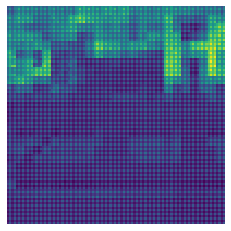

In [30]:
plt.imshow(y_hat.reshape(100, 100))
plt.axis("off")

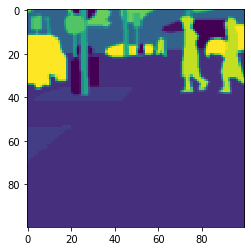

In [31]:
plt.imshow(y.reshape(100, 100))